# Emojify_V2

This text classification tasks combines language and emotion by associating words or phrases with emojis.

Our model of choice, the Recurrent Neural Network (RNN), facilitates a deeper understanding of context and expression through its sequential processing capability.

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-03-31 20:54:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-31 20:54:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-31 20:54:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
import numpy as np
import tensorflow as tf
import csv
from keras.layers import TextVectorization, LSTM, Dropout, Dense, Input, Embedding
from keras.models import Sequential

## Embeddings

This code loads pre-trained word embeddings from a file and organizes them for quick access. It reads each line of the file to extract words and their respective embedding vectors, storing them in a dictionary. Additionally, it creates mappings between words and their indices, as well as indices and words. These mappings facilitate efficient word representation and retrieval in natural language processing tasks.

In [4]:
EMBD_DIM = 50
path = f'glove.6B.{EMBD_DIM}d.txt'

def get_embeddings(path):
  embeddings = {}
  with open(path, 'r') as file:
    for line in file:
      lst = line.split()
      word = lst[0]
      embeddings[word] = np.array(lst[1:], dtype='float32')

  i = 2
  word_to_index = {}
  index_to_word = {}

  # index_to_word[0] = ''
  # index_to_word[1] = 'UNK'
  # word_to_index[''] = 0
  # word_to_index['UNK'] = 1

  for w in embeddings.keys():
    word_to_index[w] = i
    index_to_word[i] = w
    i += 1

  return embeddings, index_to_word, word_to_index


In [5]:
embeddings, index_to_word, word_to_index = get_embeddings(path)

In [6]:
len(embeddings)

400000

In [7]:
!unzip emojify.zip

Archive:  emojify.zip
   creating: emojify/
  inflating: emojify/emojify_data.csv  
  inflating: emojify/tes.csv         
  inflating: emojify/tess.csv        
  inflating: emojify/tesss.csv       
  inflating: emojify/test_emoji.csv  
  inflating: emojify/train_emoji.csv  


## Load Dataset

In [8]:
def read_data(path):
  phrases = []
  labels = []
  with open(path, 'r') as file:
    reader = csv.reader(file)
    for line in reader:
      phrases.append(line[0])
      labels.append(int(line[1]))

  return np.array(phrases), np.array(labels)


In [9]:
train_path = '/content/emojify/train_emoji.csv'
test_path = '/content/emojify/tesss.csv'

X_train, y_train = read_data(train_path)
X_test, y_test = read_data(test_path)

In [10]:
print(X_train.shape)
print(y_train.shape)

(132,)
(132,)


In [11]:
print(X_test.shape)
print(y_test.shape)

(56,)
(56,)


In [12]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 5.9 MB/s eta 0:00:00


In [13]:
import emoji
emoji_dictionary = {0: ":grey_heart:",
                    1: ":baseball:",
                    2: ":smiling_face_with_smiling_eyes:",
                    3: ":disappointed_face:",
                    4: ":fork_and_knife:"}

## Visualization

In [14]:
for i in range(10):
  print(X_train[i],emoji.emojize(emoji_dictionary[y_train[i]]))

never talk to me again 😞
I am proud of your achievements 😊
It is the worst day in my life 😞
Miss you so much 🩶
food is life 🍴
I love you mum 🩶
Stop saying bullshit 😞
congratulations on your acceptance 😊
The assignment is too long  😞
I want to go play ⚾


In [15]:
MAX_TOKEN = len(embeddings) + 2
embedding_matrix = np.zeros((MAX_TOKEN, EMBD_DIM))
embedding_matrix[2:] = np.array(list(embeddings.values()))

In [16]:
embedding_matrix[10] == embeddings[index_to_word[10]]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [17]:
MAX_LEN = max([len(x.split()) for x in X_train])
MAX_LEN

10

## Vectorize Layer
This code initializes a `TextVectorization` layer in TensorFlow, which helps prepare text data for neural network training. It sets parameters like `max_tokens` and `output_sequence_length` to control vocabulary size and sequence length. By providing a predefined vocabulary list, it ensures consistency with earlier word-to-index mappings. Overall, this layer simplifies text preprocessing, making it ready for use in neural network models.


In [18]:
vectorize_layer = TextVectorization(max_tokens=MAX_TOKEN, output_sequence_length = MAX_LEN,
                                    vocabulary=list(word_to_index.keys()))

In [19]:
vectorize_layer('I love you')

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 43, 837,  83,   0,   0,   0,   0,   0,   0,   0])>

In [20]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Create Pipline

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATH_SIZE = 32
SHUFFLE_BUFFER = 100

def vectorize(X_train, y_train):
  vec = vectorize_layer(X_train)
  return vec, y_train


training = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training = training.map(vectorize, num_parallel_calls=AUTOTUNE)
training = training.cache()
training = training.shuffle(SHUFFLE_BUFFER)
training = training.batch(BATH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
training = training.prefetch(AUTOTUNE)

test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test = test.map(vectorize, num_parallel_calls=AUTOTUNE)
test = test.cache()
test = test.batch(BATH_SIZE, num_parallel_calls=AUTOTUNE)
test = test.prefetch(AUTOTUNE)


In [23]:
for x, lbl in training:
  print(x.shape, lbl.shape)

(32, 10) (32, 5)
(32, 10) (32, 5)
(32, 10) (32, 5)
(32, 10) (32, 5)


## Model

This model is a sequential neural network designed for text classification tasks. It processes input text data through several layers:

1. **Input Layer**: Defines the shape for input sequences.
2. **Embedding Layer**: Converts word indices into dense vectors using pre-trained embeddings.
3. **Two LSTM Layers**: These layers capture sequential patterns in the input data. The first LSTM layer returns sequences, while the second one doesn't.
4. **Dropout Layers**: Applied after each LSTM layer to prevent overfitting by randomly dropping input units.
5. **Dense Layer**: Produces output probabilities for classification using softmax activation.

Overall, this model is well-suited for analyzing and classifying textual data into one of five classes, leveraging the sequential information within the text.

In [41]:
model = Sequential()
model.add(Input((MAX_LEN, )))
model.add(Embedding(MAX_TOKEN, EMBD_DIM, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(128))
model.add(Dropout(0.7))
model.add(Dense(5, activation='softmax'))

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 50)            20000100  
                                                                 
 lstm_6 (LSTM)               (None, 10, 128)           91648     
                                                                 
 dropout_6 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 20223977 (77.15 MB)
Trainable params: 22

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(1e-3), metrics=['accuracy'] )

## Training

In [43]:
history = model.fit(training, epochs = 300)

Epoch 1/300
4/4 [==============================] - 4s 34ms/step - loss: 1.5965 - accuracy: 0.2578
Epoch 2/300
4/4 [==============================] - 0s 31ms/step - loss: 1.5314 - accuracy: 0.3203
Epoch 3/300
4/4 [==============================] - 0s 31ms/step - loss: 1.5374 - accuracy: 0.3125
Epoch 4/300
4/4 [==============================] - 0s 32ms/step - loss: 1.4892 - accuracy: 0.2891
Epoch 5/300
4/4 [==============================] - 0s 34ms/step - loss: 1.4140 - accuracy: 0.3906
Epoch 6/300
4/4 [==============================] - 0s 35ms/step - loss: 1.3418 - accuracy: 0.4531
Epoch 7/300
4/4 [==============================] - 0s 41ms/step - loss: 1.2155 - accuracy: 0.5234
Epoch 8/300
4/4 [==============================] - 0s 38ms/step - loss: 1.1343 - accuracy: 0.6172
Epoch 9/300
4/4 [==============================] - 0s 37ms/step - loss: 1.0507 - accuracy: 0.6172
Epoch 10/300
4/4 [==============================] - 0s 36ms/step - loss: 0.9304 - accuracy: 0.6719
Epoch 11/300
4/4 [=

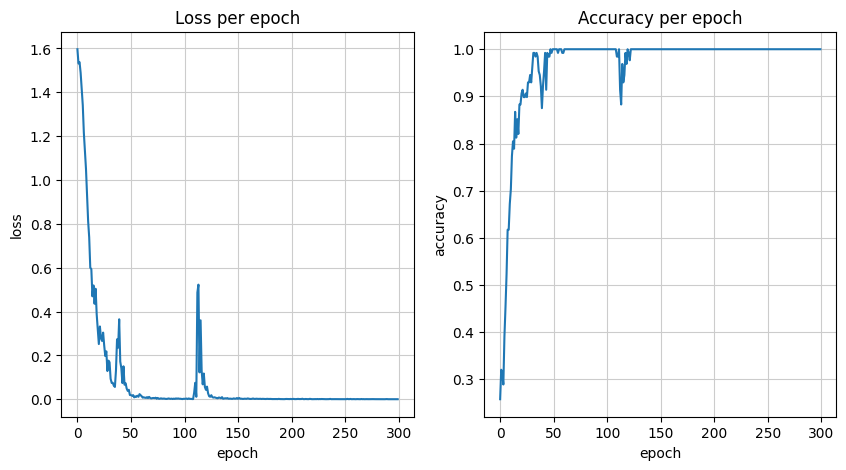

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.plot(history.epoch, history.history['loss'])
ax.set_title('Loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(c='#ccc')

ax = plt.subplot(122)
ax.plot(history.epoch, history.history['accuracy'])
ax.set_title('Accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.grid(c='#ccc')

In [45]:
eval_loss, eval_accuracy = model.evaluate(test)

2/2 [==============================] - 1s 18ms/step - loss: 0.5791 - accuracy: 0.9107


In [46]:
y_pred = model.predict(test)
y_pred = tf.argmax(y_pred, axis = 1)
y_test_p = tf.argmax(y_test, axis = 1)
wrong = np.array(y_test_p) == np.array(y_pred)
wrong = tf.where(wrong == False).numpy().flatten()

for w in wrong:
    print(f'{X_test[w]:>40}', ': True emoji is', emoji.emojize(emoji_dictionary[np.array(y_test_p)[w]]), 'Predicted', emoji.emojize(emoji_dictionary[y_pred[w].numpy()]))

2/2 [==============================] - 2s 21ms/step
           This girl is messing with me	 : True emoji is 😞 Predicted 🩶
                       work is horrible	 : True emoji is 😞 Predicted 😊
                   I love taking breaks	 : True emoji is 🩶 Predicted 😞
                    you brighten my day	 : True emoji is 😊 Predicted 🩶
               will you be my valentine	 : True emoji is 😊 Predicted 🩶


## Test the model

In [47]:

test_sentences = [
    'i adore you',
    'i hate you',
    'i am not feeling happy',
    'i am not hungry',
    'i am scared of you',
    'i want dinner',
    'he is a good friend'
]

y_test_pred = np.argmax(model.predict(vectorize_layer(test_sentences), verbose=0), axis=-1)
for i, s in enumerate(test_sentences):
      print(f'{s:>40}', ' -- > Predicted', emoji.emojize(emoji_dictionary[y_test_pred[i]]))

                             i adore you  -- > Predicted 🩶
                              i hate you  -- > Predicted 😞
                  i am not feeling happy  -- > Predicted 😞
                         i am not hungry  -- > Predicted 😞
                      i am scared of you  -- > Predicted 😞
                           i want dinner  -- > Predicted 🍴
                     he is a good friend  -- > Predicted 😊
